# Аспектный анализ тональности текстов

* [1] https://github.com/nlpub/pymystem3
* [2] SentiRuEval2015
* [3] https://rusvectores.org/ru/models/

In [1]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
# import sys; sys.path.append('./stepik-dl-nlp')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

## Оригинальная разметка

In [3]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_sentiments = 'datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'

In [4]:
from dlnlputils.sentiment_utils import parse_xml_sentiment, parse_xml_aspect, show_markup

тексты с разметкой аспектов и тональностей: 

In [5]:
texts_w_sentiment_spans = parse_xml_sentiment(xml_sentiments)
texts_w_aspect_spans    = parse_xml_aspect(xml_sentiments)

In [6]:
amount = len(texts_w_sentiment_spans)

print('Загружено {} текстов с разметкой тональности\n'.format(amount))

Загружено 217 текстов с разметкой тональности



##### выберем 2 текста, на которых будем рассматривать все примеры:

In [7]:
random_picks = [random.randint(0,amount-1) for _ in range(0,2)]

####  тональность (sentiment)

In [8]:
for rand_i in random_picks:
    text, spans = texts_w_sentiment_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 76


BoxMarkup('Сегодня я купил машину лада гранта и ни как не могу ее продать начнем с покупки машина мне обошлась в четыреста восемдесят тысяч рублей на реканий на машину нет стоимость масла 850 рублей замена бампера 5000 рублей если собираетесь делать ремонт машины капитально, то стоимость обойдется в районе 200000 рублей мощьность у нее 100 лошадей макс скорость 185 км в час. Общее впечатление : замечательный автомобиль',
          [Span(16, 34, 'neutral'),
           Span(80, 86, 'neutral'),
           Span(129, 135, 'neutral'),
           Span(150, 156, 'positive'),
           Span(161, 176, 'neutral'),
           Span(208, 214, 'neutral'),
           Span(239, 252, 'neutral'),
           Span(268, 277, 'neutral'),
           Span(311, 320, 'neutral'),
           Span(331, 338, 'neutral'),
           Span(339, 352, 'neutral'),
           Span(401, 411, 'positive')])

Текст №: 43


BoxMarkup('Начну с того, что на Тойоте Хайс работает мой муж и уже давненько. Поначалу машинка очень понравилась и внешне, и внутренне. Муж был просто в восторге, что его по работе пересадили с Баргузина на Хайс, и не замечал недостатков в этой машине. А так как он периодически отвозит меня на работу и забирает с работы на ней, то и я волей-неволей столкнулась с этой машиной. Конечно, после Баргузина Хайс казался просто нереальной машиной. И удобство кресел в салоне, и плавность хода, и внешний вид, всё приводило в восторг. Муж даже начал бредить идеей, что для нашей большой семьи (у нас трое деток) покупка такой машины в семью будет идеальной. Даже в мечтах обрисовывал, как он переделает салон под междугородние путешествия всей семьёй. Но прошло уже года три-четыре, как он работает на Тойоте Хайс. Сейчас могу сказать только одно: машина ужасная до безобразия. В этом мы убедились оба. Начну с того, что проживаем мы в северном районе нашей страны, и, соответственно, машина эксплуатируется зимой при довольно низких температурах. Так вот, в зимний период салон прогревается только в зоне передних сидений (водителя и пассажира), и то кое-как. В самом салоне машина не прогревается, несмотря на дополнительные печки и всевозможные регуляторы температуры нагрева. Так же зимой на поворотах (например, на перекрёстке) очень сильно заносит заднюю часть автомобиля. Ну это понятно - задний привод и всё остальное прочее. Но заносы эти, даже глядя со стороны, приводят в тихую жуть. Хайсов по городу бегает достаточное количество и регулярно наблюдается картина с этими заносами. Дверь на салазках снаружи открывается ужасно - женская половина пассажиров, в том числе и я, регулярно ломают ногти, так как ручка сделана не очень хорошо и с неё постоянно соскальзывают пальцы. В водительской части салона в принципе всё довольно неплохо, за исключением торпеды, которая после недолгой эксплуатации автомобиля начала греметь, что само по себе уже не приятно. Да и сам кузов Хайса начал скрипеть, чем сразу заслужил гордое звание "Сарай". Сервисное обслуживание в Тойота-центре нашего города тоже ниже плинтуса. Машина хоть и обслуживается за счёт организации, но после каждого ТО мой муж, мягко говоря, в шоке от того, как сервис-менеджеры каждый раз находят на ровном месте какие-то "болячки" у машины, дабы содрать побольше денег. А те поломки, которые действительно требуют серьёзного внимания, в заказ-наряде прописываются, но специалисты даже и не заглядывают туда. Таким образом, мой муж половину этой зимы проездил с "инвалидным" задним правым колесом: с места тронуться было невозможно - оно просто не крутилось, приходилось его срывать. Вобщем, впечатление от Хайса не айс (прям каламбур получился). Внешне, да, выглядит красиво и величественно. Но на самом деле такой же "сарай" как Баргузин, Газель и прочее. Одно, что кочки пятой точкой не чувствуешь :) За такую цену ожидаешь лучшего качества. ',
          [Span(21, 32, 'neutral'),
           Span(76, 83, 'positive'),
           Span(104, 110, 'positive'),
           Span(183, 192, 'neutral'),
           Span(196, 200, 'positive'),
           Span(234, 240, 'both'),
           Span(359, 366, 'neutral'),
           Span(383, 392, 'neutral'),
           Span(393, 397, 'positive'),
           Span(424, 431, 'positive'),
           Span(435, 443, 'positive'),
           Span(444, 459, 'positive'),
           Span(463, 477, 'positive'),
           Span(481, 492, 'positive'),
           Span(610, 616, 'positive'),
           Span(687, 692, 'neutral'),
           Span(786, 797, 'neutral'),
           Span(832, 838, 'negative'),
           Span(969, 975, 'neutral'),
           Span(1057, 1062, 'negative'),
           Span(1063, 1075, 'negative'),
           Span(1090, 1106, 'negative'),
           Span(1160, 1166, 'negative'),
           Span(1167, 1182, 'negative'),
           Span(1211, 1216, 'neutral'),
           Span(1232, 1262, 'neutral'),
           Span(1277, 1289, 'negative'),
           Span(1330, 1337, 'negat

####  Аспекты (aspects)

In [9]:
for rand_i in random_picks:
    text,spans = texts_w_aspect_spans[rand_i]
    
    print('Текст №:',rand_i)
    show_markup(text,spans)

Текст №: 76


BoxMarkup('Сегодня я купил машину лада гранта и ни как не могу ее продать начнем с покупки машина мне обошлась в четыреста восемдесят тысяч рублей на реканий на машину нет стоимость масла 850 рублей замена бампера 5000 рублей если собираетесь делать ремонт машины капитально, то стоимость обойдется в районе 200000 рублей мощьность у нее 100 лошадей макс скорость 185 км в час. Общее впечатление : замечательный автомобиль',
          [Span(16, 34, 'Whole'),
           Span(80, 86, 'Costs'),
           Span(129, 135, 'Costs'),
           Span(150, 156, 'Whole'),
           Span(161, 176, 'Costs'),
           Span(208, 214, 'Costs'),
           Span(239, 252, 'Costs'),
           Span(268, 277, 'Costs'),
           Span(311, 320, 'Driveability'),
           Span(331, 338, 'Driveability'),
           Span(339, 352, 'Driveability'),
           Span(401, 411, 'Whole')])

Текст №: 43


BoxMarkup('Начну с того, что на Тойоте Хайс работает мой муж и уже давненько. Поначалу машинка очень понравилась и внешне, и внутренне. Муж был просто в восторге, что его по работе пересадили с Баргузина на Хайс, и не замечал недостатков в этой машине. А так как он периодически отвозит меня на работу и забирает с работы на ней, то и я волей-неволей столкнулась с этой машиной. Конечно, после Баргузина Хайс казался просто нереальной машиной. И удобство кресел в салоне, и плавность хода, и внешний вид, всё приводило в восторг. Муж даже начал бредить идеей, что для нашей большой семьи (у нас трое деток) покупка такой машины в семью будет идеальной. Даже в мечтах обрисовывал, как он переделает салон под междугородние путешествия всей семьёй. Но прошло уже года три-четыре, как он работает на Тойоте Хайс. Сейчас могу сказать только одно: машина ужасная до безобразия. В этом мы убедились оба. Начну с того, что проживаем мы в северном районе нашей страны, и, соответственно, машина эксплуатируется зимой при довольно низких температурах. Так вот, в зимний период салон прогревается только в зоне передних сидений (водителя и пассажира), и то кое-как. В самом салоне машина не прогревается, несмотря на дополнительные печки и всевозможные регуляторы температуры нагрева. Так же зимой на поворотах (например, на перекрёстке) очень сильно заносит заднюю часть автомобиля. Ну это понятно - задний привод и всё остальное прочее. Но заносы эти, даже глядя со стороны, приводят в тихую жуть. Хайсов по городу бегает достаточное количество и регулярно наблюдается картина с этими заносами. Дверь на салазках снаружи открывается ужасно - женская половина пассажиров, в том числе и я, регулярно ломают ногти, так как ручка сделана не очень хорошо и с неё постоянно соскальзывают пальцы. В водительской части салона в принципе всё довольно неплохо, за исключением торпеды, которая после недолгой эксплуатации автомобиля начала греметь, что само по себе уже не приятно. Да и сам кузов Хайса начал скрипеть, чем сразу заслужил гордое звание "Сарай". Сервисное обслуживание в Тойота-центре нашего города тоже ниже плинтуса. Машина хоть и обслуживается за счёт организации, но после каждого ТО мой муж, мягко говоря, в шоке от того, как сервис-менеджеры каждый раз находят на ровном месте какие-то "болячки" у машины, дабы содрать побольше денег. А те поломки, которые действительно требуют серьёзного внимания, в заказ-наряде прописываются, но специалисты даже и не заглядывают туда. Таким образом, мой муж половину этой зимы проездил с "инвалидным" задним правым колесом: с места тронуться было невозможно - оно просто не крутилось, приходилось его срывать. Вобщем, впечатление от Хайса не айс (прям каламбур получился). Внешне, да, выглядит красиво и величественно. Но на самом деле такой же "сарай" как Баргузин, Газель и прочее. Одно, что кочки пятой точкой не чувствуешь :) За такую цену ожидаешь лучшего качества. ',
          [Span(21, 32, 'Whole'),
           Span(76, 83, 'Whole'),
           Span(104, 110, 'Appearance'),
           Span(183, 192, 'Whole'),
           Span(196, 200, 'Whole'),
           Span(234, 240, 'Whole'),
           Span(359, 366, 'Whole'),
           Span(383, 392, 'Whole'),
           Span(393, 397, 'Whole'),
           Span(424, 431, 'Whole'),
           Span(435, 443, 'Comfort'),
           Span(444, 459, 'Comfort'),
           Span(463, 477, 'Driveability'),
           Span(481, 492, 'Appearance'),
           Span(610, 616, 'Whole'),
           Span(687, 692, 'Comfort'),
           Span(786, 797, 'Whole'),
           Span(832, 838, 'Whole'),
           Span(969, 975, 'Whole'),
           Span(1057, 1062, 'Comfort'),
           Span(1063, 1075, 'Comfort'),
           Span(1090, 1106, 'Comfort'),
           Span(1160, 1166, 'Comfort'),
           Span(1167, 1182, 'Comfort'),
           Span(1211, 1216, 'Comfort'),
           Span(1232, 1262, 'Comfort'),
           Span(1277, 1289, 'Driveability'),
           Span(1330, 1337, 'Driveability'),
           Sp

## BIO-тэги для обучения модели

In [10]:
from dlnlputils.sentiment_utils import fill_gaps, extract_BIO_tagged_tokens

In [11]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]
    cover_spans       = fill_gaps(text, aspect_spans)
    
    print('Полное покрытие разметкой текста №:',rand_i) 
    show_markup(text, cover_spans)

Полное покрытие разметкой текста №: 76


BoxMarkup('Сегодня я купил машину лада гранта и ни как не могу ее продать начнем с покупки машина мне обошлась в четыреста восемдесят тысяч рублей на реканий на машину нет стоимость масла 850 рублей замена бампера 5000 рублей если собираетесь делать ремонт машины капитально, то стоимость обойдется в районе 200000 рублей мощьность у нее 100 лошадей макс скорость 185 км в час. Общее впечатление : замечательный автомобиль',
          [Span(0, 16, 'Other'),
           Span(16, 34, 'Whole'),
           Span(34, 80, 'Other'),
           Span(80, 86, 'Costs'),
           Span(86, 129, 'Other'),
           Span(129, 135, 'Costs'),
           Span(135, 150, 'Other'),
           Span(150, 156, 'Whole'),
           Span(156, 161, 'Other'),
           Span(161, 176, 'Costs'),
           Span(176, 208, 'Other'),
           Span(208, 214, 'Costs'),
           Span(214, 239, 'Other'),
           Span(239, 252, 'Costs'),
           Span(252, 268, 'Other'),
           Span(268, 277, 'Costs'),
           Span(277, 311, 'Other'),
           Span(311, 320, 'Driveability'),
           Span(320, 331, 'Other'),
           Span(331, 338, 'Driveability'),
           Span(338, 339, 'Other'),
           Span(339, 352, 'Driveability'),
           Span(352, 401, 'Other'),
           Span(401, 411, 'Whole')])

Полное покрытие разметкой текста №: 43


BoxMarkup('Начну с того, что на Тойоте Хайс работает мой муж и уже давненько. Поначалу машинка очень понравилась и внешне, и внутренне. Муж был просто в восторге, что его по работе пересадили с Баргузина на Хайс, и не замечал недостатков в этой машине. А так как он периодически отвозит меня на работу и забирает с работы на ней, то и я волей-неволей столкнулась с этой машиной. Конечно, после Баргузина Хайс казался просто нереальной машиной. И удобство кресел в салоне, и плавность хода, и внешний вид, всё приводило в восторг. Муж даже начал бредить идеей, что для нашей большой семьи (у нас трое деток) покупка такой машины в семью будет идеальной. Даже в мечтах обрисовывал, как он переделает салон под междугородние путешествия всей семьёй. Но прошло уже года три-четыре, как он работает на Тойоте Хайс. Сейчас могу сказать только одно: машина ужасная до безобразия. В этом мы убедились оба. Начну с того, что проживаем мы в северном районе нашей страны, и, соответственно, машина эксплуатируется зимой при довольно низких температурах. Так вот, в зимний период салон прогревается только в зоне передних сидений (водителя и пассажира), и то кое-как. В самом салоне машина не прогревается, несмотря на дополнительные печки и всевозможные регуляторы температуры нагрева. Так же зимой на поворотах (например, на перекрёстке) очень сильно заносит заднюю часть автомобиля. Ну это понятно - задний привод и всё остальное прочее. Но заносы эти, даже глядя со стороны, приводят в тихую жуть. Хайсов по городу бегает достаточное количество и регулярно наблюдается картина с этими заносами. Дверь на салазках снаружи открывается ужасно - женская половина пассажиров, в том числе и я, регулярно ломают ногти, так как ручка сделана не очень хорошо и с неё постоянно соскальзывают пальцы. В водительской части салона в принципе всё довольно неплохо, за исключением торпеды, которая после недолгой эксплуатации автомобиля начала греметь, что само по себе уже не приятно. Да и сам кузов Хайса начал скрипеть, чем сразу заслужил гордое звание "Сарай". Сервисное обслуживание в Тойота-центре нашего города тоже ниже плинтуса. Машина хоть и обслуживается за счёт организации, но после каждого ТО мой муж, мягко говоря, в шоке от того, как сервис-менеджеры каждый раз находят на ровном месте какие-то "болячки" у машины, дабы содрать побольше денег. А те поломки, которые действительно требуют серьёзного внимания, в заказ-наряде прописываются, но специалисты даже и не заглядывают туда. Таким образом, мой муж половину этой зимы проездил с "инвалидным" задним правым колесом: с места тронуться было невозможно - оно просто не крутилось, приходилось его срывать. Вобщем, впечатление от Хайса не айс (прям каламбур получился). Внешне, да, выглядит красиво и величественно. Но на самом деле такой же "сарай" как Баргузин, Газель и прочее. Одно, что кочки пятой точкой не чувствуешь :) За такую цену ожидаешь лучшего качества. ',
          [Span(0, 21, 'Other'),
           Span(21, 32, 'Whole'),
           Span(32, 76, 'Other'),
           Span(76, 83, 'Whole'),
           Span(83, 104, 'Other'),
           Span(104, 110, 'Appearance'),
           Span(110, 183, 'Other'),
           Span(183, 192, 'Whole'),
           Span(192, 196, 'Other'),
           Span(196, 200, 'Whole'),
           Span(200, 234, 'Other'),
           Span(234, 240, 'Whole'),
           Span(240, 359, 'Other'),
           Span(359, 366, 'Whole'),
           Span(366, 383, 'Other'),
           Span(383, 392, 'Whole'),
           Span(392, 393, 'Other'),
           Span(393, 397, 'Whole'),
           Span(397, 424, 'Other'),
           Span(424, 431, 'Whole'),
           Span(431, 435, 'Other'),
           Span(435, 443, 'Comfort'),
           Span(443, 444, 'Other'),
           Span(444, 459, 'Comfort'),
           Span(459, 463, 'Other'),
           Span(463, 477, 'Driveability'),
           Span(477, 481, 'Other'),
           Span(481, 492, 'Appearance'),
           Span(492, 610, 'Other'),
           Span(610, 616, 'Whol

### Разбиение текста на предложения, а предложений - на слова.

In [12]:
from dlnlputils.sentiment_utils import regex_sentence_detector, sentence_spans,sentence_splitter

In [13]:
from nltk.tokenize import RegexpTokenizer

word_tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

In [14]:
for rand_i in random_picks:
    text, aspect_spans = texts_w_aspect_spans[rand_i]

    print('Разбиение на предложения и BIO токенизация текста №:',rand_i) 
    for sentence, spans in sentence_splitter(text, aspect_spans):

        cover_spans      = fill_gaps(sentence,spans)
        tokens_w_biotags = extract_BIO_tagged_tokens(sentence, 
                                                     cover_spans, 
                                                     word_tokenizer.tokenize)

        show_markup(sentence, cover_spans)
        print(tokens_w_biotags[:10],'\n')

Разбиение на предложения и BIO токенизация текста №: 76


BoxMarkup('Сегодня я купил машину лада гранта и ни как не могу ее продать начнем с покупки машина мне обошлась в четыреста восемдесят тысяч рублей на реканий на машину нет стоимость масла 850 рублей замена бампера 5000 рублей если собираетесь делать ремонт машины капитально, то стоимость обойдется в районе 200000 рублей мощьность у нее 100 лошадей макс скорость 185 км в час.',
          [Span(0, 16, 'Other'),
           Span(16, 34, 'Whole'),
           Span(34, 80, 'Other'),
           Span(80, 86, 'Costs'),
           Span(86, 129, 'Other'),
           Span(129, 135, 'Costs'),
           Span(135, 150, 'Other'),
           Span(150, 156, 'Whole'),
           Span(156, 161, 'Other'),
           Span(161, 176, 'Costs'),
           Span(176, 208, 'Other'),
           Span(208, 214, 'Costs'),
           Span(214, 239, 'Other'),
           Span(239, 252, 'Costs'),
           Span(252, 268, 'Other'),
           Span(268, 277, 'Costs'),
           Span(277, 311, 'Other'),
           Span(311, 320, 'Driveability'),
           Span(320, 331, 'Other'),
           Span(331, 338, 'Driveability'),
           Span(338, 339, 'Other'),
           Span(339, 352, 'Driveability'),
           Span(352, 366, 'Other')])

[('Сегодня', 'Other'), ('я', 'Other'), ('купил', 'Other'), ('машину', 'B-Whole'), ('лада', 'I-Whole'), ('гранта', 'I-Whole'), ('и', 'Other'), ('ни', 'Other'), ('как', 'Other'), ('не', 'Other')] 



BoxMarkup('Общее впечатление : замечательный автомобиль',
          [Span(0, 34, 'Other'), Span(34, 44, 'Whole')])

[('Общее', 'Other'), ('впечатление', 'Other'), (':', 'Other'), ('замечательный', 'Other'), ('автомобиль', 'B-Whole')] 

Разбиение на предложения и BIO токенизация текста №: 43


BoxMarkup('Начну с того, что на Тойоте Хайс работает мой муж и уже давненько.',
          [Span(0, 21, 'Other'), Span(21, 32, 'Whole'), Span(32, 66, 'Other')])

[('Начну', 'Other'), ('с', 'Other'), ('того', 'Other'), (',', 'Other'), ('что', 'Other'), ('на', 'Other'), ('Тойоте', 'B-Whole'), ('Хайс', 'I-Whole'), ('работает', 'Other'), ('мой', 'Other')] 



BoxMarkup('Поначалу машинка очень понравилась и внешне, и внутренне.',
          [Span(0, 9, 'Other'),
           Span(9, 16, 'Whole'),
           Span(16, 37, 'Other'),
           Span(37, 43, 'Appearance'),
           Span(43, 57, 'Other')])

[('Поначалу', 'Other'), ('машинка', 'B-Whole'), ('очень', 'Other'), ('понравилась', 'Other'), ('и', 'Other'), ('внешне', 'B-Appearance'), (',', 'Other'), ('и', 'Other'), ('внутренне', 'Other'), ('.', 'Other')] 



BoxMarkup('Муж был просто в восторге, что его по работе пересадили с Баргузина на Хайс, и не замечал недостатков в этой машине.',
          [Span(0, 58, 'Other'),
           Span(58, 67, 'Whole'),
           Span(67, 71, 'Other'),
           Span(71, 75, 'Whole'),
           Span(75, 109, 'Other'),
           Span(109, 115, 'Whole')])

[('Муж', 'Other'), ('был', 'Other'), ('просто', 'Other'), ('в', 'Other'), ('восторге', 'Other'), (',', 'Other'), ('что', 'Other'), ('его', 'Other'), ('по', 'Other'), ('работе', 'Other')] 



BoxMarkup('А так как он периодически отвозит меня на работу и забирает с работы на ней, то и я волей-неволей столкнулась с этой машиной.',
          [Span(0, 117, 'Other'), Span(117, 124, 'Whole')])

[('А', 'Other'), ('так', 'Other'), ('как', 'Other'), ('он', 'Other'), ('периодически', 'Other'), ('отвозит', 'Other'), ('меня', 'Other'), ('на', 'Other'), ('работу', 'Other'), ('и', 'Other')] 



BoxMarkup('Конечно, после Баргузина Хайс казался просто нереальной машиной.',
          [Span(0, 15, 'Other'),
           Span(15, 24, 'Whole'),
           Span(24, 25, 'Other'),
           Span(25, 29, 'Whole'),
           Span(29, 56, 'Other'),
           Span(56, 63, 'Whole')])

[('Конечно', 'Other'), (',', 'Other'), ('после', 'Other'), ('Баргузина', 'B-Whole'), ('Хайс', 'B-Whole'), ('казался', 'Other'), ('просто', 'Other'), ('нереальной', 'Other'), ('машиной', 'B-Whole')] 



BoxMarkup('И удобство кресел в салоне, и плавность хода, и внешний вид, всё приводило в восторг.',
          [Span(0, 2, 'Other'),
           Span(2, 10, 'Comfort'),
           Span(10, 11, 'Other'),
           Span(11, 26, 'Comfort'),
           Span(26, 30, 'Other'),
           Span(30, 44, 'Driveability'),
           Span(44, 48, 'Other'),
           Span(48, 59, 'Appearance'),
           Span(59, 85, 'Other')])

[('И', 'Other'), ('удобство', 'B-Comfort'), ('кресел', 'B-Comfort'), ('в', 'I-Comfort'), ('салоне', 'I-Comfort'), (',', 'Other'), ('и', 'Other'), ('плавность', 'B-Driveability'), ('хода', 'I-Driveability'), (',', 'Other')] 



BoxMarkup('Муж даже начал бредить идеей, что для нашей большой семьи (у нас трое деток) покупка такой машины в семью будет идеальной.',
          [Span(0, 91, 'Other'),
           Span(91, 97, 'Whole'),
           Span(97, 122, 'Other')])

[('Муж', 'Other'), ('даже', 'Other'), ('начал', 'Other'), ('бредить', 'Other'), ('идеей', 'Other'), (',', 'Other'), ('что', 'Other'), ('для', 'Other'), ('нашей', 'Other'), ('большой', 'Other')] 



BoxMarkup('Даже в мечтах обрисовывал, как он переделает салон под междугородние путешествия всей семьёй.',
          [Span(0, 45, 'Other'),
           Span(45, 50, 'Comfort'),
           Span(50, 93, 'Other')])

[('Даже', 'Other'), ('в', 'Other'), ('мечтах', 'Other'), ('обрисовывал', 'Other'), (',', 'Other'), ('как', 'Other'), ('он', 'Other'), ('переделает', 'Other'), ('салон', 'B-Comfort'), ('под', 'Other')] 



BoxMarkup('Но прошло уже года три-четыре, как он работает на Тойоте Хайс.',
          [Span(0, 50, 'Other'), Span(50, 61, 'Whole')])

[('Но', 'Other'), ('прошло', 'Other'), ('уже', 'Other'), ('года', 'Other'), ('три', 'Other'), ('-четыре,', 'Other'), ('как', 'Other'), ('он', 'Other'), ('работает', 'Other'), ('на', 'Other')] 



BoxMarkup('Сейчас могу сказать только одно: машина ужасная до безобразия.',
          [Span(0, 33, 'Other'), Span(33, 39, 'Whole'), Span(39, 62, 'Other')])

[('Сейчас', 'Other'), ('могу', 'Other'), ('сказать', 'Other'), ('только', 'Other'), ('одно', 'Other'), (':', 'Other'), ('машина', 'B-Whole'), ('ужасная', 'Other'), ('до', 'Other'), ('безобразия', 'Other')] 



BoxMarkup('В этом мы убедились оба.', [Span(0, 24, 'Other')])

[('В', 'Other'), ('этом', 'Other'), ('мы', 'Other'), ('убедились', 'Other'), ('оба', 'Other'), ('.', 'Other')] 



BoxMarkup('Начну с того, что проживаем мы в северном районе нашей страны, и, соответственно, машина эксплуатируется зимой при довольно низких температурах.',
          [Span(0, 82, 'Other'),
           Span(82, 88, 'Whole'),
           Span(88, 144, 'Other')])

[('Начну', 'Other'), ('с', 'Other'), ('того', 'Other'), (',', 'Other'), ('что', 'Other'), ('проживаем', 'Other'), ('мы', 'Other'), ('в', 'Other'), ('северном', 'Other'), ('районе', 'Other')] 



BoxMarkup('Так вот, в зимний период салон прогревается только в зоне передних сидений (водителя и пассажира), и то кое-как.',
          [Span(0, 25, 'Other'),
           Span(25, 30, 'Comfort'),
           Span(30, 31, 'Other'),
           Span(31, 43, 'Comfort'),
           Span(43, 58, 'Other'),
           Span(58, 74, 'Comfort'),
           Span(74, 112, 'Other')])

[('Так', 'Other'), ('вот', 'Other'), (',', 'Other'), ('в', 'Other'), ('зимний', 'Other'), ('период', 'Other'), ('салон', 'B-Comfort'), ('прогревается', 'B-Comfort'), ('только', 'Other'), ('в', 'Other')] 



BoxMarkup('В самом салоне машина не прогревается, несмотря на дополнительные печки и всевозможные регуляторы температуры нагрева.',
          [Span(0, 15, 'Other'),
           Span(15, 21, 'Comfort'),
           Span(21, 22, 'Other'),
           Span(22, 37, 'Comfort'),
           Span(37, 66, 'Other'),
           Span(66, 71, 'Comfort'),
           Span(71, 87, 'Other'),
           Span(87, 117, 'Comfort')])

[('В', 'Other'), ('самом', 'Other'), ('салоне', 'Other'), ('машина', 'B-Comfort'), ('не', 'B-Comfort'), ('прогревается', 'I-Comfort'), (',', 'Other'), ('несмотря', 'Other'), ('на', 'Other'), ('дополнительные', 'Other')] 



BoxMarkup('Так же зимой на поворотах (например, на перекрёстке) очень сильно заносит заднюю часть автомобиля.',
          [Span(0, 13, 'Other'),
           Span(13, 25, 'Driveability'),
           Span(25, 66, 'Other'),
           Span(66, 73, 'Driveability'),
           Span(73, 74, 'Other'),
           Span(74, 97, 'Driveability')])

[('Так', 'Other'), ('же', 'Other'), ('зимой', 'Other'), ('на', 'B-Driveability'), ('поворотах', 'I-Driveability'), ('(например,', 'Other'), ('на', 'Other'), ('перекрёстке', 'Other'), (')', 'Other'), ('очень', 'Other')] 



BoxMarkup('Ну это понятно - задний привод и всё остальное прочее.',
          [Span(0, 17, 'Other'),
           Span(17, 30, 'Driveability'),
           Span(30, 54, 'Other')])

[('Ну', 'Other'), ('это', 'Other'), ('понятно', 'Other'), ('-', 'Other'), ('задний', 'B-Driveability'), ('привод', 'I-Driveability'), ('и', 'Other'), ('всё', 'Other'), ('остальное', 'Other'), ('прочее', 'Other')] 



BoxMarkup('Но заносы эти, даже глядя со стороны, приводят в тихую жуть.',
          [Span(0, 3, 'Other'),
           Span(3, 9, 'Driveability'),
           Span(9, 60, 'Other')])

[('Но', 'Other'), ('заносы', 'B-Driveability'), ('эти', 'Other'), (',', 'Other'), ('даже', 'Other'), ('глядя', 'Other'), ('со', 'Other'), ('стороны', 'Other'), (',', 'Other'), ('приводят', 'Other')] 



BoxMarkup('Хайсов по городу бегает достаточное количество и регулярно наблюдается картина с этими заносами.',
          [Span(0, 6, 'Driveability'),
           Span(6, 87, 'Other'),
           Span(87, 95, 'Driveability')])

[('Хайсов', 'B-Driveability'), ('по', 'Other'), ('городу', 'Other'), ('бегает', 'Other'), ('достаточное', 'Other'), ('количество', 'Other'), ('и', 'Other'), ('регулярно', 'Other'), ('наблюдается', 'Other'), ('картина', 'Other')] 



BoxMarkup('Дверь на салазках снаружи открывается ужасно - женская половина пассажиров, в том числе и я, регулярно ломают ногти, так как ручка сделана не очень хорошо и с неё постоянно соскальзывают пальцы.',
          [Span(0, 17, 'Comfort'),
           Span(17, 26, 'Other'),
           Span(26, 44, 'Comfort'),
           Span(44, 125, 'Other'),
           Span(125, 130, 'Comfort'),
           Span(130, 194, 'Other')])

[('Дверь', 'B-Comfort'), ('на', 'I-Comfort'), ('салазках', 'I-Comfort'), ('снаружи', 'Other'), ('открывается', 'B-Comfort'), ('ужасно', 'I-Comfort'), ('-', 'Other'), ('женская', 'Other'), ('половина', 'Other'), ('пассажиров', 'Other')] 



BoxMarkup('В водительской части салона в принципе всё довольно неплохо, за исключением торпеды, которая после недолгой эксплуатации автомобиля начала греметь, что само по себе уже не приятно.',
          [Span(0, 2, 'Other'),
           Span(2, 27, 'Comfort'),
           Span(27, 76, 'Other'),
           Span(76, 83, 'Comfort'),
           Span(83, 139, 'Other'),
           Span(139, 146, 'Comfort'),
           Span(146, 180, 'Other')])

[('В', 'Other'), ('водительской', 'B-Comfort'), ('части', 'I-Comfort'), ('салона', 'I-Comfort'), ('в', 'Other'), ('принципе', 'Other'), ('всё', 'Other'), ('довольно', 'Other'), ('неплохо', 'Other'), (',', 'Other')] 



BoxMarkup('Да и сам кузов Хайса начал скрипеть, чем сразу заслужил гордое звание "Сарай".',
          [Span(0, 9, 'Other'),
           Span(9, 20, 'Comfort'),
           Span(20, 27, 'Other'),
           Span(27, 35, 'Comfort'),
           Span(35, 70, 'Other'),
           Span(70, 77, 'Reliability')])

[('Да', 'Other'), ('и', 'Other'), ('сам', 'Other'), ('кузов', 'B-Comfort'), ('Хайса', 'I-Comfort'), ('начал', 'Other'), ('скрипеть', 'B-Comfort'), (',', 'Other'), ('чем', 'Other'), ('сразу', 'Other')] 



BoxMarkup('Сервисное обслуживание в Тойота-центре нашего города тоже ниже плинтуса.',
          [Span(0, 22, 'Reliability'), Span(22, 72, 'Other')])

[('Сервисное', 'B-Reliability'), ('обслуживание', 'I-Reliability'), ('в', 'Other'), ('Тойота', 'Other'), ('-центре', 'Other'), ('нашего', 'Other'), ('города', 'Other'), ('тоже', 'Other'), ('ниже', 'Other'), ('плинтуса', 'Other')] 



BoxMarkup('Машина хоть и обслуживается за счёт организации, но после каждого ТО мой муж, мягко говоря, в шоке от того, как сервис-менеджеры каждый раз находят на ровном месте какие-то "болячки" у машины, дабы содрать побольше денег.',
          [Span(0, 6, 'Reliability'),
           Span(6, 66, 'Other'),
           Span(66, 68, 'Reliability'),
           Span(68, 185, 'Other'),
           Span(185, 191, 'Costs'),
           Span(191, 198, 'Other'),
           Span(198, 220, 'Costs')])

[('Машина', 'B-Reliability'), ('хоть', 'Other'), ('и', 'Other'), ('обслуживается', 'Other'), ('за', 'Other'), ('счёт', 'Other'), ('организации', 'Other'), (',', 'Other'), ('но', 'Other'), ('после', 'Other')] 



BoxMarkup('А те поломки, которые действительно требуют серьёзного внимания, в заказ-наряде прописываются, но специалисты даже и не заглядывают туда.',
          [Span(0, 5, 'Other'),
           Span(5, 12, 'Reliability'),
           Span(12, 137, 'Other')])

[('А', 'Other'), ('те', 'Other'), ('поломки', 'B-Reliability'), (',', 'Other'), ('которые', 'Other'), ('действительно', 'Other'), ('требуют', 'Other'), ('серьёзного', 'Other'), ('внимания', 'Other'), (',', 'Other')] 



BoxMarkup('Таким образом, мой муж половину этой зимы проездил с "инвалидным" задним правым колесом: с места тронуться было невозможно - оно просто не крутилось, приходилось его срывать.',
          [Span(0, 53, 'Other'),
           Span(53, 65, 'Reliability'),
           Span(65, 66, 'Other'),
           Span(66, 87, 'Reliability'),
           Span(87, 89, 'Other'),
           Span(89, 106, 'Driveability'),
           Span(106, 136, 'Other'),
           Span(136, 148, 'Reliability'),
           Span(148, 166, 'Other'),
           Span(166, 173, 'Driveability')])

[('Таким', 'Other'), ('образом', 'Other'), (',', 'Other'), ('мой', 'Other'), ('муж', 'Other'), ('половину', 'Other'), ('этой', 'Other'), ('зимы', 'Other'), ('проездил', 'Other'), ('с', 'Other')] 



BoxMarkup('Вобщем, впечатление от Хайса не айс (прям каламбур получился).',
          [Span(0, 23, 'Other'), Span(23, 28, 'Whole'), Span(28, 62, 'Other')])

[('Вобщем', 'Other'), (',', 'Other'), ('впечатление', 'Other'), ('от', 'Other'), ('Хайса', 'B-Whole'), ('не', 'Other'), ('айс', 'Other'), ('(прям', 'Other'), ('каламбур', 'Other'), ('получился', 'Other')] 



BoxMarkup('Внешне, да, выглядит красиво и величественно.',
          [Span(0, 6, 'Appearance'),
           Span(6, 12, 'Other'),
           Span(12, 20, 'Appearance'),
           Span(20, 21, 'Other'),
           Span(21, 28, 'Appearance'),
           Span(28, 31, 'Other'),
           Span(31, 44, 'Appearance')])

[('Внешне', 'B-Appearance'), (',', 'Other'), ('да', 'Other'), (',', 'Other'), ('выглядит', 'B-Appearance'), ('красиво', 'B-Appearance'), ('и', 'Other'), ('величественно', 'B-Appearance')] 



BoxMarkup('Но на самом деле такой же "сарай" как Баргузин, Газель и прочее.',
          [Span(0, 26, 'Other'),
           Span(26, 33, 'Reliability'),
           Span(33, 38, 'Other'),
           Span(38, 46, 'Reliability'),
           Span(46, 48, 'Other'),
           Span(48, 54, 'Reliability'),
           Span(54, 64, 'Other')])

[('Но', 'Other'), ('на', 'Other'), ('самом', 'Other'), ('деле', 'Other'), ('такой', 'Other'), ('же', 'Other'), ('"сарай"', 'B-Reliability'), ('как', 'Other'), ('Баргузин', 'B-Reliability'), (',', 'Other')] 



BoxMarkup('Одно, что кочки пятой точкой не чувствуешь :) За такую цену ожидаешь лучшего качества.',
          [Span(0, 10, 'Other'),
           Span(10, 42, 'Driveability'),
           Span(42, 55, 'Other'),
           Span(55, 59, 'Costs'),
           Span(59, 77, 'Other'),
           Span(77, 85, 'Reliability')])

[('Одно', 'Other'), (',', 'Other'), ('что', 'Other'), ('кочки', 'B-Driveability'), ('пятой', 'I-Driveability'), ('точкой', 'I-Driveability'), ('не', 'I-Driveability'), ('чувствуешь', 'I-Driveability'), (':)', 'Other'), ('За', 'Other')] 



BoxMarkup('', [])

[] 



##  Подготовка данных для обучения: 

In [15]:
from dlnlputils.sentiment_utils import prepare_data, form_vocabulary_and_tagset

In [16]:
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp
xml_train = 'datasets/sentirueval2015/SentiRuEval_car_markup_train.xml'
xml_test  = 'datasets/sentirueval2015/SentiRuEval_car_markup_test.xml'

### Токенизация: 

In [17]:
texts_w_aspect_spans = parse_xml_aspect(xml_train)
training_data        = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)

texts_w_aspect_spans = parse_xml_aspect(xml_test)
test_data            = prepare_data(texts_w_aspect_spans, word_tokenizer.tokenize)


#### разбиение на предложения дало нам столько коротких текстов:

In [18]:
len(training_data), len(test_data)

(2210, 1922)

In [19]:
all_data = training_data + test_data

In [20]:
vocabulary,labels = form_vocabulary_and_tagset(all_data)

In [21]:
labels

{'B-Appearance',
 'B-Comfort',
 'B-Costs',
 'B-Driveability',
 'B-Reliability',
 'B-Safety',
 'B-Whole',
 'I-Appearance',
 'I-Comfort',
 'I-Costs',
 'I-Driveability',
 'I-Reliability',
 'I-Safety',
 'I-Whole',
 'Other'}

#### а размер словаря:

In [22]:
len(vocabulary), len(labels)

(11333, 15)

#### индексация:

In [23]:
from dlnlputils.sentiment_utils import Converter, generate_markup

In [24]:
converter = Converter(vocabulary,labels)

In [25]:
test_recipe, test_tags = training_data[1211]

text, spans = generate_markup(test_recipe, test_tags) 

show_markup(text, spans)

encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()

decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

text, spans = generate_markup(decoded_recipe, decoded_tags) 

show_markup(text, spans)

BoxMarkup('За первых три года не было ни одной поломки , потом стали проявляться мелкие неисправности : подшипник на полуоси , лампочки дальнего ближнего света , крестовины , аккумулятор , свечи',
          [Span(0, 26, 'Other'),
           Span(27, 43, 'Reliability'),
           Span(44, 76, 'Other'),
           Span(77, 90, 'Reliability'),
           Span(91, 92, 'Other'),
           Span(93, 113, 'Reliability'),
           Span(114, 115, 'Other'),
           Span(116, 148, 'Reliability'),
           Span(149, 150, 'Other'),
           Span(151, 161, 'Reliability'),
           Span(162, 163, 'Other'),
           Span(164, 175, 'Reliability'),
           Span(176, 177, 'Other'),
           Span(178, 183, 'Reliability')])

tensor([ 1395,  7307, 10381,  3591,  6303,  2877,  6524,  6847,  7826,   289,
         8063,  9912,  8648,  5768,  6381,   823,  7653,  6064,  7835,   289,
         5435,  3739,  2737,  9234,   289,  5331,   289,  2540,   289,  9247])
tensor([14, 14, 14, 14, 14, 14,  4, 11, 11, 14, 14, 14, 14, 14,  4, 14,  4, 11,
        11, 14,  4, 11, 11, 11, 14,  4, 14,  4, 14,  4])



BoxMarkup('За первых три года не было ни одной поломки , потом стали проявляться мелкие неисправности : подшипник на полуоси , лампочки дальнего ближнего света , крестовины , аккумулятор , свечи',
          [Span(0, 26, 'Other'),
           Span(27, 43, 'Reliability'),
           Span(44, 76, 'Other'),
           Span(77, 90, 'Reliability'),
           Span(91, 92, 'Other'),
           Span(93, 113, 'Reliability'),
           Span(114, 115, 'Other'),
           Span(116, 148, 'Reliability'),
           Span(149, 150, 'Other'),
           Span(151, 161, 'Reliability'),
           Span(162, 163, 'Other'),
           Span(164, 175, 'Reliability'),
           Span(176, 177, 'Other'),
           Span(178, 183, 'Reliability')])

### Нейросети

In [26]:
EMBEDDING_DIM = 300
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

###  Предобученные векторы слов

Алгоритм fastText обученный на корпусе Тайга, смотрите подробности на сайте: https://rusvectores.org/ru/models/


In [27]:
# !pip3 install wget

In [28]:
import zipfile
import gensim
#import wget

model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
#wget.download(model_url)
model_file = 'datasets/' + model_url.split('/')[-1]

In [29]:
w2v_model = gensim.models.KeyedVectors.load('datasets/187/model.model')

words = ['тачка', 'двигатель', 'ауди']

for word in words:
    #if word in w2v_model:
           
    for i in w2v_model.most_similar(positive=[word], topn=10):
        nearest_word      = i[0]
        cosine_similarity = i[1]
        print(nearest_word, cosine_similarity)
    print('\n')
    
    #else: print(word + ' is not present in the model')

жигулёнка 0.7488205432891846
ишачка 0.7310285568237305
грузовичка 0.7278668880462646
жигулёнок 0.7127147912979126
жигуленок 0.706432044506073
тележка 0.6995413899421692
мопед 0.6990943551063538
сачка 0.6923120021820068
катафалка 0.6904969811439514
бричка 0.6855131387710571


двигатели 0.9118232727050781
гипердвигатель 0.8655393123626709
электродвигатель 0.8446589708328247
мотор 0.8106047511100769
электромотор 0.8067886233329773
авиадвигатель 0.7910490036010742
движок 0.7793391346931458
перводвигатель 0.7768319249153137
двигательный 0.7394744157791138
турбина 0.7326768636703491


bmw 0.7961359620094299
бмв 0.7914925813674927
аудь 0.7911134958267212
тойота 0.7723557353019714
мерседес 0.7654416561126709
mw 0.7585864067077637
bmv 0.7522681951522827
форд 0.7281615734100342
тойот 0.7268385887145996
лексус 0.7258473038673401




In [31]:
numpy_embeddings = np.zeros(shape=[VOCAB_SIZE, EMBEDDING_DIM],dtype=np.float32)

for word in vocabulary:
    #if word in w2v_model:
    vector = w2v_model.get_vector(word)
    index  = converter.words_to_index([word])
    numpy_embeddings[index] = vector
        
    #else: print(word + ' - такого слова нет в модели fasttext')
        
pretrained_embeddings = torch.FloatTensor(numpy_embeddings)
pretrained_embeddings.shape

torch.Size([11333, 300])

### LSTM 

1. Использует предобученные вектора слов и не изменяет их
2. Двунаправленная

In [32]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pretrained_embeddings):
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True)
        self.hidden2tag      = nn.Linear(2*hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

### Взвешеная функция потерь

In [33]:
from collections import Counter

tag_counter = Counter()
for _,tokens in training_data:
    for token in tokens:
        tag_counter[token]+=1
        
tag_counter.most_common()     

[('Other', 23529),
 ('B-Driveability', 1188),
 ('B-Comfort', 1092),
 ('I-Driveability', 773),
 ('B-Reliability', 769),
 ('B-Whole', 768),
 ('I-Comfort', 480),
 ('I-Reliability', 457),
 ('B-Costs', 392),
 ('B-Appearance', 354),
 ('I-Whole', 310),
 ('I-Costs', 177),
 ('I-Appearance', 146),
 ('B-Safety', 87),
 ('I-Safety', 63)]

In [34]:
class_weights = torch.ones(15)
class_divs    = torch.ones(15)

for tag, inv_weight in tag_counter.most_common():
    tag_idx             = converter.tags_to_index([tag])
    class_divs[tag_idx] = inv_weight
    
norm       = torch.norm(class_divs, p=2, dim=0).detach()
class_divs = class_divs.div(norm.expand_as(class_divs))


class_weights /= class_divs


print(class_weights.detach())

tensor([ 66.7812,  21.6488,  60.3075,  19.8994,  30.7419, 271.7303,  30.7819,
        161.9215,  49.2511, 133.5623,  30.5828,  51.7298, 375.2466,  76.2598,
          1.0047])


In [35]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE, pretrained_embeddings)
loss_function = nn.NLLLoss(class_weights) 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

#### training

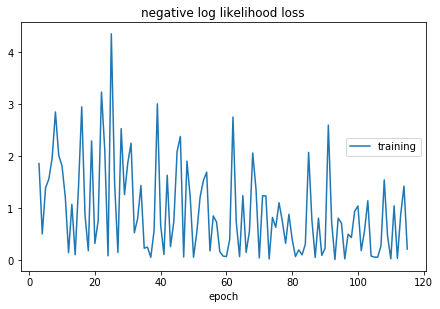

negative log likelihood loss:
training   (min:    0.011, max:    4.351, cur:    0.211)


In [36]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(5): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
        encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
        tag_scores     = model(encoded_recipe)
        
        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        
        if i % 100 == 0:
            liveplot.update({'negative log likelihood loss': loss})
            liveplot.draw()
            

In [37]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре

    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags

In [38]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,1000)]
    
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    text, spans = generate_markup(recipe, tags) 
    show_markup(text, spans)

    print('предсказанные тэги:')
    text, spans = generate_markup(recipe, tags_pred) 

    show_markup(text, spans)
    print()

истинные тэги:


BoxMarkup('Вот из чего им удалось сделать конфетку так это из небольших коммерческих автомобилей , но вот уже Fiat Ducato вечный аутсайдер среди больших автобусов , по дизайну видно , что Fiat Ducato пытается скопировать Peouget Boxer , фары и форма одни и те же во всяком случае и если поставить их рядом друг с другом , то особой разницы во внешности не будет , однако в начинке , Мы все знаем , что Французы пока еще впереди , да и по цене лям достаточно накладно отдавать за аутсайдера .',
          [Span(0, 60, 'Other'),
           Span(61, 85, 'Whole'),
           Span(86, 98, 'Other'),
           Span(99, 110, 'Whole'),
           Span(111, 156, 'Other'),
           Span(157, 164, 'Appearance'),
           Span(165, 176, 'Other'),
           Span(177, 188, 'Appearance'),
           Span(189, 209, 'Other'),
           Span(210, 223, 'Appearance'),
           Span(224, 225, 'Other'),
           Span(226, 230, 'Appearance'),
           Span(231, 232, 'Other'),
           Span(233, 238, 'Appearance'),
           Span(239, 331, 'Other'),
           Span(332, 341, 'Appearance'),
           Span(342, 361, 'Other'),
           Span(362, 369, 'Driveability'),
           Span(370, 426, 'Other'),
           Span(427, 431, 'Costs'),
           Span(432, 446, 'Other'),
           Span(447, 455, 'Costs'),
           Span(456, 480, 'Other')])

предсказанные тэги:


BoxMarkup('Вот из чего им удалось сделать конфетку так это из небольших коммерческих автомобилей , но вот уже Fiat Ducato вечный аутсайдер среди больших автобусов , по дизайну видно , что Fiat Ducato пытается скопировать Peouget Boxer , фары и форма одни и те же во всяком случае и если поставить их рядом друг с другом , то особой разницы во внешности не будет , однако в начинке , Мы все знаем , что Французы пока еще впереди , да и по цене лям достаточно накладно отдавать за аутсайдера .',
          [Span(0, 47, 'Other'),
           Span(48, 50, 'Whole'),
           Span(51, 60, 'Other'),
           Span(61, 87, 'Whole'),
           Span(88, 90, 'Other'),
           Span(91, 94, 'Whole'),
           Span(95, 98, 'Other'),
           Span(99, 110, 'Whole'),
           Span(111, 117, 'Driveability'),
           Span(118, 127, 'Whole'),
           Span(128, 141, 'Other'),
           Span(142, 151, 'Whole'),
           Span(152, 156, 'Other'),
           Span(157, 170, 'Appearance'),
           Span(171, 176, 'Other'),
           Span(177, 181, 'Comfort'),
           Span(182, 197, 'Other'),
           Span(198, 209, 'Appearance'),
           Span(210, 238, 'Whole'),
           Span(239, 331, 'Other'),
           Span(332, 341, 'Appearance'),
           Span(342, 408, 'Other'),
           Span(409, 416, 'Driveability'),
           Span(417, 426, 'Other'),
           Span(427, 435, 'Costs'),
           Span(436, 446, 'Other'),
           Span(447, 455, 'Reliability'),
           Span(456, 480, 'Other')])


истинные тэги:


BoxMarkup('В общем , ребят , подведу итог , не берите себе данный автомобиль ! Общее впечатление : Отечественный автомобиль -погремушка',
          [Span(0, 54, 'Other'),
           Span(55, 65, 'Whole'),
           Span(66, 101, 'Other'),
           Span(102, 124, 'Comfort')])

предсказанные тэги:


BoxMarkup('В общем , ребят , подведу итог , не берите себе данный автомобиль ! Общее впечатление : Отечественный автомобиль -погремушка',
          [Span(0, 47, 'Other'),
           Span(48, 65, 'Whole'),
           Span(66, 87, 'Other'),
           Span(88, 124, 'Whole')])


истинные тэги:


BoxMarkup('Автомобиль был куплен в апреле 2010 года в салоне Тагаз .',
          [Span(0, 10, 'Whole'), Span(11, 57, 'Other')])

предсказанные тэги:


BoxMarkup('Автомобиль был куплен в апреле 2010 года в салоне Тагаз .',
          [Span(0, 10, 'Whole'),
           Span(11, 42, 'Other'),
           Span(43, 49, 'Comfort'),
           Span(50, 55, 'Whole'),
           Span(56, 57, 'Other')])


истинные тэги:


BoxMarkup('У меня был Ваз 2112 2006 .',
          [Span(0, 10, 'Other'), Span(11, 19, 'Whole'), Span(20, 26, 'Other')])

предсказанные тэги:


BoxMarkup('У меня был Ваз 2112 2006 .',
          [Span(0, 10, 'Other'),
           Span(11, 19, 'Whole'),
           Span(20, 24, 'Other'),
           Span(25, 26, 'Whole')])


истинные тэги:


BoxMarkup('Одним словом заливай бензин , проходи ТО и катайся в своё удовольствие ! Общее впечатление : Хороший , качественный автомобиль без изысков',
          [Span(0, 20, 'Other'),
           Span(21, 27, 'Driveability'),
           Span(28, 37, 'Other'),
           Span(38, 40, 'Reliability'),
           Span(41, 102, 'Other'),
           Span(103, 115, 'Reliability'),
           Span(116, 126, 'Whole'),
           Span(127, 138, 'Other')])

предсказанные тэги:


BoxMarkup('Одним словом заливай бензин , проходи ТО и катайся в своё удовольствие ! Общее впечатление : Хороший , качественный автомобиль без изысков',
          [Span(0, 12, 'Other'),
           Span(13, 27, 'Driveability'),
           Span(28, 29, 'Other'),
           Span(30, 37, 'Driveability'),
           Span(38, 42, 'Other'),
           Span(43, 50, 'Reliability'),
           Span(51, 102, 'Other'),
           Span(103, 126, 'Whole'),
           Span(127, 130, 'Driveability'),
           Span(131, 138, 'Other')])


истинные тэги:


BoxMarkup('Салон комфортный насколько может быть комфортный авто за эти деньги',
          [Span(0, 16, 'Comfort'),
           Span(17, 37, 'Other'),
           Span(38, 53, 'Comfort'),
           Span(54, 60, 'Other'),
           Span(61, 67, 'Costs')])

предсказанные тэги:


BoxMarkup('Салон комфортный насколько может быть комфортный авто за эти деньги',
          [Span(0, 26, 'Comfort'),
           Span(27, 37, 'Other'),
           Span(38, 48, 'Comfort'),
           Span(49, 53, 'Whole'),
           Span(54, 56, 'Other'),
           Span(57, 60, 'Whole'),
           Span(61, 67, 'Costs')])


истинные тэги:


BoxMarkup('Расход бензина маленький - 7 .5 литров на 100 километров .',
          [Span(0, 14, 'Driveability'), Span(15, 58, 'Other')])

предсказанные тэги:


BoxMarkup('Расход бензина маленький - 7 .5 литров на 100 километров .',
          [Span(0, 14, 'Driveability'), Span(15, 58, 'Other')])


истинные тэги:


BoxMarkup('Есть один нюанс .', [Span(0, 17, 'Other')])

предсказанные тэги:


BoxMarkup('Есть один нюанс .', [Span(0, 17, 'Other')])


истинные тэги:


BoxMarkup('иначе сильная вибрация по кузову , вместе с ней сразу стоит поменять и остальные подушки , это еще 3 т .',
          [Span(0, 13, 'Other'),
           Span(14, 32, 'Comfort'),
           Span(33, 80, 'Other'),
           Span(81, 88, 'Reliability'),
           Span(89, 104, 'Other')])

предсказанные тэги:


BoxMarkup('иначе сильная вибрация по кузову , вместе с ней сразу стоит поменять и остальные подушки , это еще 3 т .',
          [Span(0, 5, 'Other'),
           Span(6, 13, 'Safety'),
           Span(14, 25, 'Driveability'),
           Span(26, 32, 'Reliability'),
           Span(33, 80, 'Other'),
           Span(81, 88, 'Safety'),
           Span(89, 104, 'Other')])


истинные тэги:


BoxMarkup('Сев за руль я сразу почувствовала не удобные сидения , заводится хорошо и трогается тоже , но когда я прокатилась я поняла что машина деревянная в каком смысле объясню .',
          [Span(0, 33, 'Other'),
           Span(34, 52, 'Comfort'),
           Span(53, 54, 'Other'),
           Span(55, 64, 'Reliability'),
           Span(65, 73, 'Other'),
           Span(74, 83, 'Driveability'),
           Span(84, 126, 'Other'),
           Span(127, 144, 'Driveability'),
           Span(145, 169, 'Other')])

предсказанные тэги:


BoxMarkup('Сев за руль я сразу почувствовала не удобные сидения , заводится хорошо и трогается тоже , но когда я прокатилась я поняла что машина деревянная в каком смысле объясню .',
          [Span(0, 19, 'Other'),
           Span(20, 33, 'Safety'),
           Span(34, 52, 'Comfort'),
           Span(53, 54, 'Other'),
           Span(55, 64, 'Reliability'),
           Span(65, 126, 'Other'),
           Span(127, 133, 'Whole'),
           Span(134, 144, 'Comfort'),
           Span(145, 169, 'Other')])

### Статистика

##### 1.  Количество верно предсказанных тэгов:

In [39]:
from dlnlputils.sentiment_utils import tag_statistics

In [40]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для Other:
  корректно:	 15840
      всего:	 19922
% корректно:	 79.51008934845899

для B-Whole:
  корректно:	 527
      всего:	 673
% корректно:	 78.30609212481427

для B-Driveability:
  корректно:	 488
      всего:	 1066
% корректно:	 45.77861163227016

для I-Driveability:
  корректно:	 290
      всего:	 711
% корректно:	 40.787623066104075

для B-Appearance:
  корректно:	 174
      всего:	 275
% корректно:	 63.272727272727266

для I-Appearance:
  корректно:	 32
      всего:	 100
% корректно:	 32.0

для B-Reliability:
  корректно:	 305
      всего:	 809
% корректно:	 37.7008652657602

для I-Whole:
  корректно:	 87
      всего:	 213
% корректно:	 40.845070422535215

для B-Comfort:
  корректно:	 610
      всего:	 1067
% корректно:	 57.16963448922212

для I-Comfort:
  корректно:	 190
      всего:	 497
% корректно:	 38.22937625754527

для I-Reliability:
  корректно:	 147
      всего:	 475
% корректно:	 30.94736842105263

для B-Costs:
  корректно:	 2

##### 2.  Количество верно предсказанных тэгов в виде матрицы ошибок:

In [41]:
from dlnlputils.sentiment_utils import plot_confusion_matrix

In [42]:
y_pred = []
y_true = []

for sentence, tags in test_data:
    y_pred += predict_tags(model, converter, sentence)
    y_true += tags

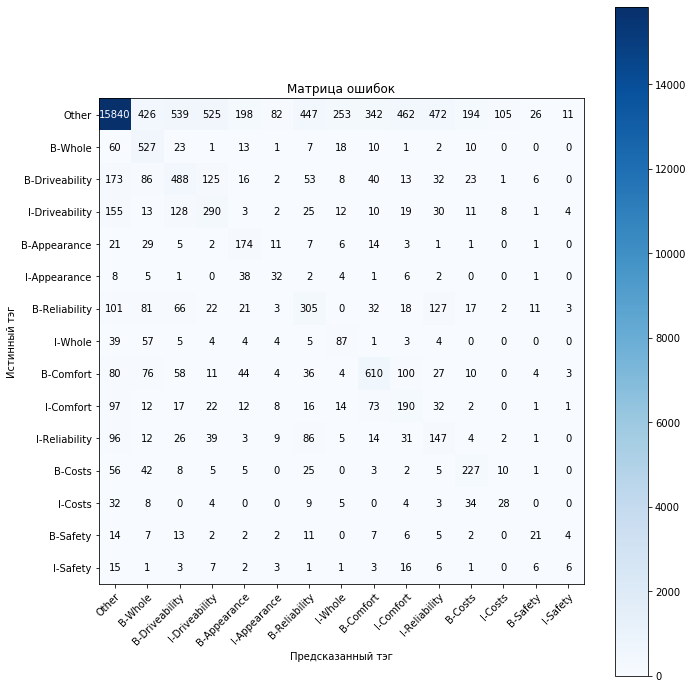

In [43]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), title='Матрица ошибок')

plt.show()

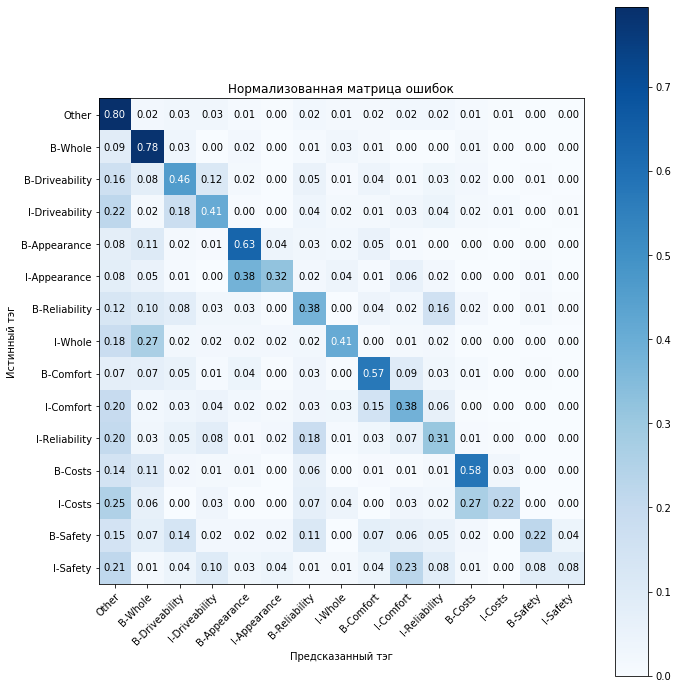

In [44]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True, 
                      title='Нормализованная матрица ошибок')

plt.show()